In [1]:
# notes:

# inventory, item stock, prediction for inventory
# f.e. next month how we will sell from each item

# top most selling products
# top most high selling products


# no missing records in the time-series model
# consecutive days - datetimeformat
# date column as index!!
# Multi-series forecasting, arima

# model prophet- from meta -> i can specify country

# Importing libraries and cleaned dataset

In [55]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from prophet.plot import plot_plotly, plot_components_plotly
from prophet import Prophet

#import holidays 

In [3]:
# Disabling a specific type of warning from Jupyter, that I know if mistaken for something else
pd.options.mode.chained_assignment = None 

**Original Dataset**:

Chen,Daqing. (2015). Online Retail. UCI Machine Learning Repository. https://archive.ics.uci.edu/dataset/352/online+retail

In [4]:
# Importing two datasets, to be able to compare performance
# onecleaned dataset from my first notebook, and one filtered with clusters from the notebook 03_ML_clustering
# the filters on the second are: nnly actual products (good), only UK, dropping NaN customerID
file_path1 = '../data/data_cleaned.csv'
file_path2 = '../data/data_filtered_with_clusters.csv'

df = pd.read_csv(file_path1, dtype={'InvoiceNo': 'O','StockCode': 'O','Description': 'O',
                                   'Quantity': 'int64','UnitPrice': 'float64',
                                   'CustomerID': 'Int64','Country': 'O'}, parse_dates=['InvoiceDate'])
df_fltrd = pd.read_csv(file_path2, dtype={'InvoiceNo': 'O','StockCode': 'O','Description': 'O',
                                   'Quantity': 'int64','UnitPrice': 'float64',
                                   'CustomerID': 'Int64','Country': 'O'}, parse_dates=['InvoiceDate'])

In [5]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.95,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.75,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,4.15,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.75,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,4.25,17850,United Kingdom


In [6]:
df_fltrd.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,Label
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.95,17850,United Kingdom,17.7,2
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.75,17850,United Kingdom,22.5,2
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,4.15,17850,United Kingdom,33.2,2
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.75,17850,United Kingdom,22.5,2
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,4.25,17850,United Kingdom,25.5,2


In [7]:
# Ading the total price column to df
df['TotalPrice'] = df.Quantity * df.UnitPrice

# Feature Engineering

### Clipping outliers

I know from the EDA, shown in the previous notebooks, two outliers with huge difference in scale. I am going to do scaling to a range, scaling them to highest next value (after these two).

In [8]:
# scaling within a range, updating the Quantity and accordingly the TotalPrice
df.loc[df.InvoiceNo.isin(['581483','541431']),'Quantity'] = df.Quantity.sort_values(ascending=False).values[2]
df.loc[df.InvoiceNo.isin(['581483','541431']),'TotalPrice'] = df.Quantity * df.UnitPrice

df_fltrd.loc[df_fltrd.InvoiceNo.isin(['581483','541431']),'Quantity'] = df_fltrd.Quantity.sort_values(ascending=False).values[2]
df_fltrd.loc[df_fltrd.InvoiceNo.isin(['581483','541431']),'TotalPrice'] = df_fltrd.Quantity * df_fltrd.UnitPrice

### Date column

Adding new column for the date without time.

In [9]:
# New date column without time
df['InvoiceDate_noTime'] = df.InvoiceDate.dt.normalize()
df_fltrd['InvoiceDate_noTime'] = df_fltrd.InvoiceDate.dt.normalize()

# New columns for year/month/day
#cust_test[['Year','Month','Day']] = cust_test.InvoiceDate.dt.strftime('%Y-%m-%d').str.split('-', n=3, expand=True)

# Defining if it is weekday or weekend
#cust_test['Weekend'] = (cust_test['InvoiceDate'].dt.dayofweek > 4).astype(int)

# Finding holidays in UK
# Currently all are False, cause in the date of holidays the online store was possibly closed
#uk_holidays = holidays.UnitedKingdom() 
#df['Holidays'] = df['InvoiceDate_noTime'].isin(uk_holidays).astype(int)

### Removing features that will not be used

I will be using StockCode, Quantity and date for my model. 

In [10]:
df_stock = df[['StockCode','Quantity','InvoiceDate_noTime']].rename(columns={'InvoiceDate_noTime':'InvoiceDate'})
df_stock

,StockCode,Quantity,InvoiceDate
0,85123A,6,2010-12-01
1,71053,6,2010-12-01
2,84406B,8,2010-12-01
3,84029G,6,2010-12-01
4,84029E,6,2010-12-01
...,...,...,...
524875,22613,12,2011-12-09
524876,22899,6,2011-12-09
524877,23254,4,2011-12-09
524878,23255,4,2011-12-09


# Splitting dataset

In [11]:
df_fltrd.Label.unique()

array([2, 1, 0, 3])

In [12]:
df_fltrd.Label.info()

<class 'pandas.core.series.Series'>
RangeIndex: 348887 entries, 0 to 348886
Series name: Label
Non-Null Count   Dtype
--------------   -----
348887 non-null  int64
dtypes: int64(1)
memory usage: 2.7 MB


In [13]:
df_fltrd_0 = df_fltrd[df_fltrd.Label == 0]
df_fltrd_1 = df_fltrd[df_fltrd.Label == 1]
df_fltrd_2 = df_fltrd[df_fltrd.Label == 2]
df_fltrd_3 = df_fltrd[df_fltrd.Label == 3]

# EDA

### Quantity sold for all products

<Axes: xlabel='InvoiceDate_noTime'>

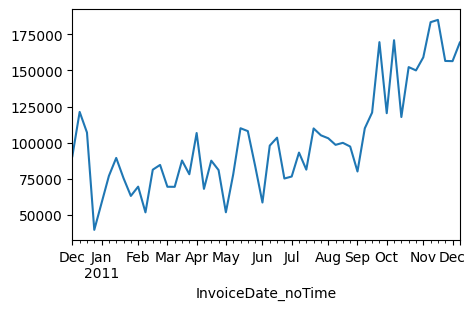

In [14]:
# per week
df.groupby(df['InvoiceDate_noTime'].dt.to_period('W'))['Quantity'].sum().plot(figsize=(5, 3))

<Axes: xlabel='InvoiceDate_noTime'>

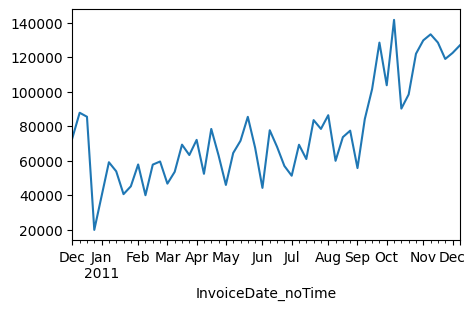

In [15]:
# per week
df_fltrd.groupby(df_fltrd['InvoiceDate_noTime'].dt.to_period('W'))['Quantity'].sum().plot(figsize=(5, 3))

<Axes: xlabel='InvoiceDate_noTime'>

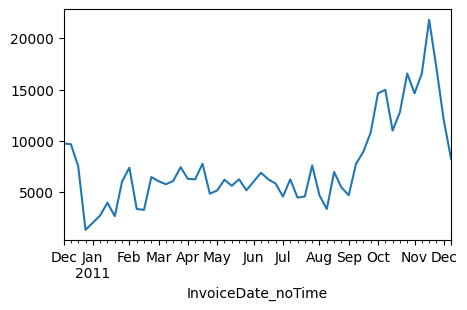

In [16]:
df_fltrd_0.groupby(df_fltrd_0['InvoiceDate_noTime'].dt.to_period('W'))['Quantity'].sum().plot(figsize=(5, 3))

<Axes: xlabel='InvoiceDate_noTime'>

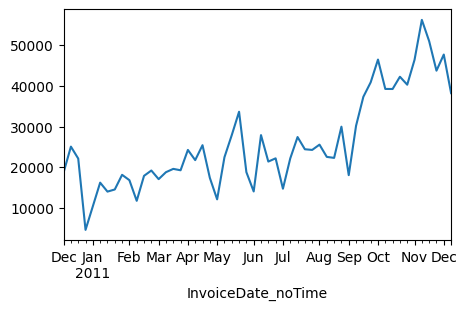

In [17]:
df_fltrd_1.groupby(df_fltrd_1['InvoiceDate_noTime'].dt.to_period('W'))['Quantity'].sum().plot(figsize=(5, 3))

<Axes: xlabel='InvoiceDate_noTime'>

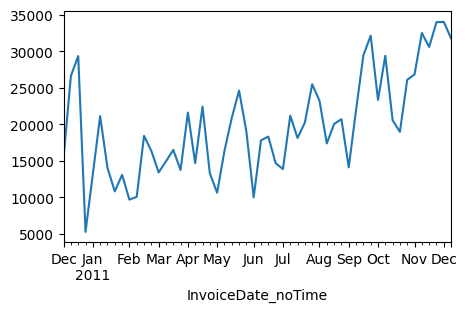

In [18]:
df_fltrd_2.groupby(df_fltrd_2['InvoiceDate_noTime'].dt.to_period('W'))['Quantity'].sum().plot(figsize=(5, 3))

<Axes: xlabel='InvoiceDate_noTime'>

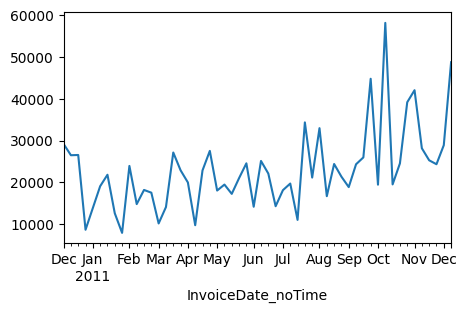

In [19]:
df_fltrd_3.groupby(df_fltrd_3['InvoiceDate_noTime'].dt.to_period('W'))['Quantity'].sum().plot(figsize=(5, 3))

# Top selling products

In [20]:
df.groupby('StockCode')['Quantity'].sum().sort_values(ascending=False)

StockCode
22197     56898
84077     54951
85099B    48371
85123A    37641
21212     36396
          ...  
85179a        1
84968f        1
37474         1
85170A        1
90178B        1
Name: Quantity, Length: 3916, dtype: int64

In [21]:
# the top 5 selling products
products_top = df.groupby('StockCode')['Quantity'].sum().sort_values(ascending=False).head(5).index.tolist()
products_top

['22197', '84077', '85099B', '85123A', '21212']

In [22]:
# Checking the top selling products per category
df_fltrd_0.groupby('StockCode')['Quantity'].sum().sort_values(ascending=False).head(5).index.tolist()

['84879', '84077', '85123A', '84946', '22178']

## Test for top selling product

In [28]:
df_stock_top_pr = df_stock[df_stock.StockCode == products_top[0]].drop(columns='StockCode').reset_index(drop=True)
df_stock_top_pr

,Quantity,InvoiceDate
0,100,2010-12-01
1,36,2010-12-01
2,2,2010-12-01
3,5,2010-12-01
4,5,2010-12-01
...,...,...
1413,100,2011-12-09
1414,34,2011-12-09
1415,68,2011-12-09
1416,4,2011-12-09


In [32]:
# Renaming for the prophet model
df_stock_top_pr.columns = ['y','ds']

# changing the order of the columns
df_stock_top_pr = df_stock_top_pr[['ds', 'y']]
df_stock_top_pr

,ds,y
0,2010-12-01,100
1,2010-12-01,36
2,2010-12-01,2
3,2010-12-01,5
4,2010-12-01,5
...,...,...
1413,2011-12-09,100
1414,2011-12-09,34
1415,2011-12-09,68
1416,2011-12-09,4


In [34]:
df_stock_top_pr.dtypes

ds    datetime64[ns]
y              int64
dtype: object

In [43]:
df_stock_top_pr.y.sort_values().tail(20)

303      480
1023     500
766      600
810      600
771      600
402      600
126      600
223      600
355      637
1159     700
1256    1000
943     1000
1361    1000
1201    1130
1412    1200
1411    1500
1144    1820
755     1900
1081    1992
536     4300
Name: y, dtype: int64

<Axes: xlabel='ds'>

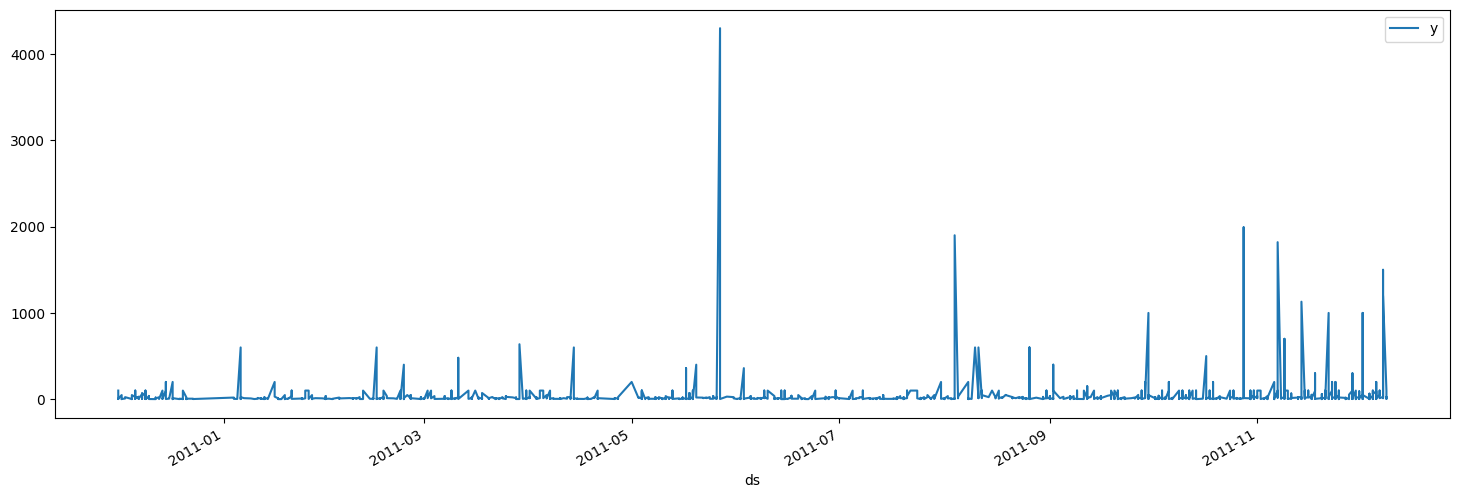

In [37]:
df_stock_top_pr.plot(x='ds',y='y',figsize=(18,6))

In [42]:
# testing outlier clipping
tq_UpperLimit = (df_stock_top_pr.y.mean() + df_stock_top_pr.y.std()*3).round(0).astype(int)
tq_UpperLimit 

556

In [44]:
# testing outlier clipping
df_stock_top_pr_clip = df_stock_top_pr.copy()
df_stock_top_pr_clip.loc[df_stock_top_pr_clip.y > tq_UpperLimit , 'y'] = tq_UpperLimit

In [45]:
# testing outlier clipping
df_stock_top_pr_clip.y.sort_values().tail(20)

303     480
1023    500
1144    556
1411    556
1412    556
766     556
1159    556
536     556
1081    556
126     556
223     556
755     556
1256    556
1201    556
810     556
402     556
1361    556
771     556
943     556
355     556
Name: y, dtype: int64

<Axes: xlabel='ds'>

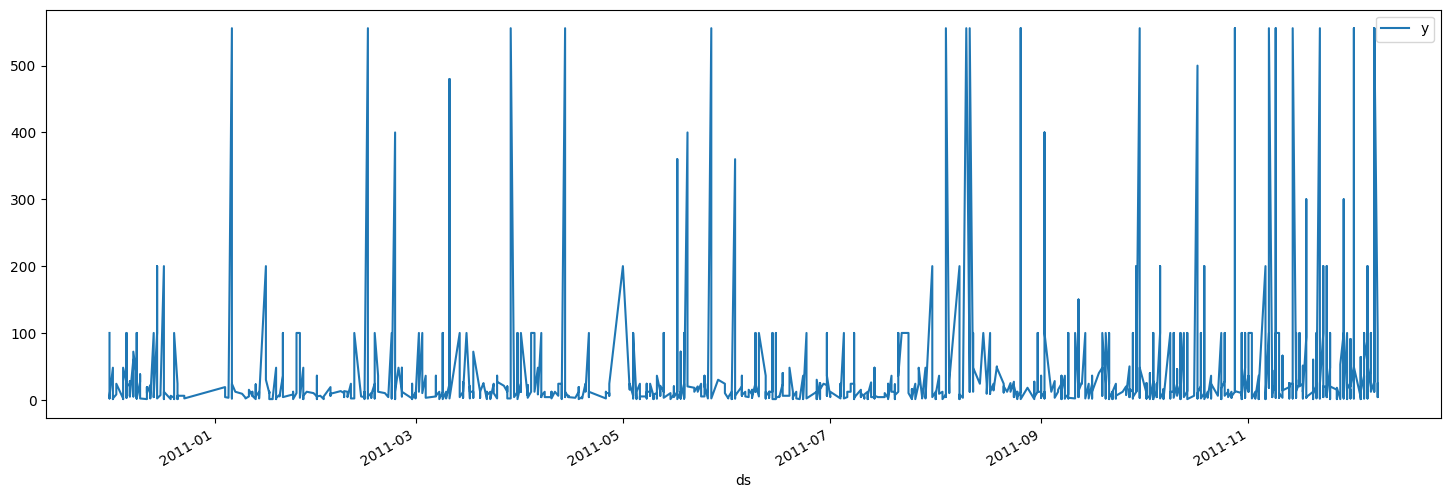

In [46]:
df_stock_top_pr_clip.plot(x='ds',y='y',figsize=(18,6))

# Train, test Split

In [48]:
365-(365*0.8)

73.0

In [49]:
train = df_stock_top_pr.iloc[:len(df_stock_top_pr)-73]
test = df_stock_top_pr.iloc[len(df_stock_top_pr)-73:]

# Prophet model

https://facebook.github.io/prophet/docs/quick_start.html

In [56]:
m = Prophet()
m.fit(train)
future = m.make_future_dataframe(periods=73)
forecast = m.predict(future)

12:16:34 - cmdstanpy - INFO - Chain [1] start processing
12:16:35 - cmdstanpy - INFO - Chain [1] done processing


In [58]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
354,2012-02-07,60.085640,-160.184582,266.788184,59.802372,60.372124,-12.848140,-12.848140,-12.848140,-12.848140,-12.848140,-12.848140,0.0,0.0,0.0,47.237500
355,2012-02-08,60.178261,-181.346282,269.650244,59.890000,60.471102,-8.338244,-8.338244,-8.338244,-8.338244,-8.338244,-8.338244,0.0,0.0,0.0,51.840017
356,2012-02-09,60.270883,-163.405949,274.657310,59.976837,60.571473,-5.657226,-5.657226,-5.657226,-5.657226,-5.657226,-5.657226,0.0,0.0,0.0,54.613656
357,2012-02-10,60.363504,-124.675679,297.722089,60.062952,60.670331,23.043162,23.043162,23.043162,23.043162,23.043162,23.043162,0.0,0.0,0.0,83.406666
358,2012-02-11,60.456126,-128.860467,294.851006,60.150153,60.767764,35.440426,35.440426,35.440426,35.440426,35.440426,35.440426,0.0,0.0,0.0,95.896552


In [59]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
354,2012-02-07,47.237500,-160.184582,266.788184
355,2012-02-08,51.840017,-181.346282,269.650244
356,2012-02-09,54.613656,-163.405949,274.657310
357,2012-02-10,83.406666,-124.675679,297.722089
358,2012-02-11,95.896552,-128.860467,294.851006


In [60]:
test.tail()

,ds,y
1413,2011-12-09,100
1414,2011-12-09,34
1415,2011-12-09,68
1416,2011-12-09,4
1417,2011-12-09,24


/Users/dimitratsagkalidou/Documents/dimi/Data_Analysis/IronHack/Unit_8/Final_project/final_project/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/dimitratsagkalidou/Documents/dimi/Data_Analysis/IronHack/Unit_8/Final_project/final_project/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


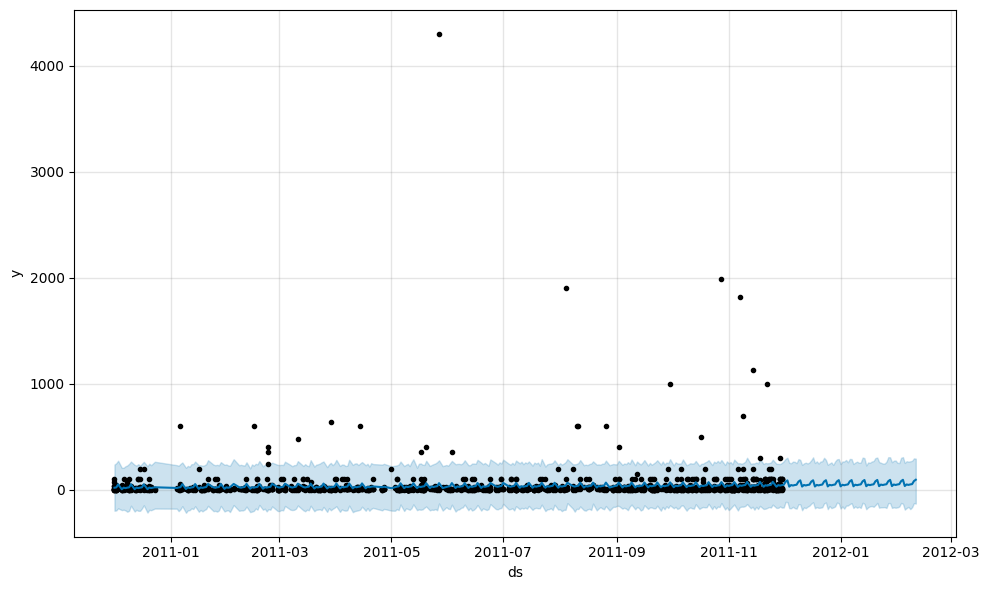

In [62]:
fig1 = m.plot(forecast)

/Users/dimitratsagkalidou/Documents/dimi/Data_Analysis/IronHack/Unit_8/Final_project/final_project/lib/python3.11/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()


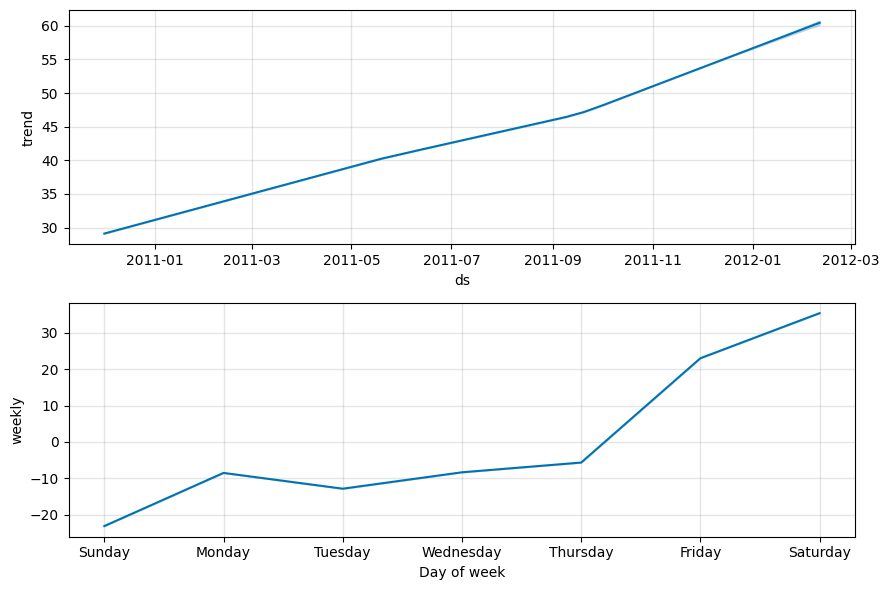

In [63]:
fig2 = m.plot_components(forecast)



In [66]:
# Evaluation
from statsmodels.tools.eval_measures import rmse

In [67]:
predictions = forecast.iloc[-73:]['yhat']
print("Root Mean Squared Error between actual and predicted values: ",rmse(predictions, test['y']))
print("Mean Value of Test Dataset: ", test['y'].mean())

Root Mean Squared Error between actual and predicted values:  246.6654384266174
Mean Value of Test Dataset:  86.91780821917808


In [ ]:
# not good

### Quantity sold for the top selling products

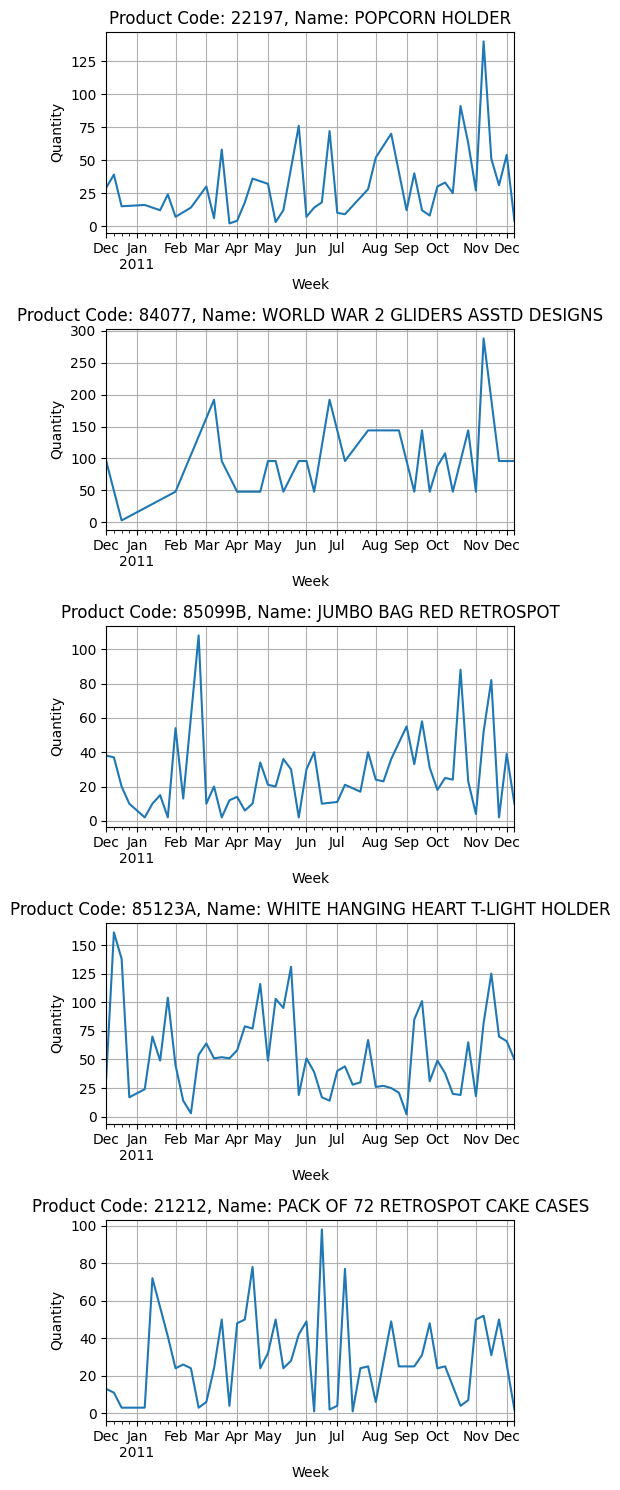

In [24]:
# Create subplots
fig, axes = plt.subplots(len(products_top), 1, figsize=(5, 3 * len(products_top)))

# Iterate over each product code
for i, code in enumerate(products_top):
    # Filter DataFrame for the current product code
    df_product = df_fltrd_0[df_fltrd_0['StockCode'] == code]
    
    # Group by week and calculate total sales, plot total sales per (week/day) for the current product code
    ax = df_product.groupby(df_product['InvoiceDate_noTime'].dt.to_period('W'))['Quantity'].sum().plot(ax=axes[i])

    ax.set_title(f"Product Code: {code}, Name: {df_fltrd_0[df_fltrd_0['StockCode'] == code].Description.mode()[0]}")
    ax.set_ylabel("Quantity")
    ax.set_xlabel("Week")
    ax.grid(True)

# Adjust layout and spacing
plt.tight_layout()
plt.show()